# Exploratory Analysis

In [1]:
import pandas as pd
import numpy as np

pd.set_option('max_colwidth', None)
pd.set_option('display.max_columns', None)
import warnings 
warnings.filterwarnings("ignore")

In [2]:
results = pd.read_csv('data/1345_customer_results.csv', index_col = "Case ID")

In [3]:
results.head(2)

,Origin,Origin Created At,Content ID,URL,Labeling State,Series,Series Index,Patch,Qualified Reads,Correct Label,Majority Label,Difficulty,Agreement,First Choice Answer,First Choice Votes,First Choice Weight,Second Choice Answer,Second Choice Votes,Second Choice Weight,Internal Notes,Comments,Explanation
Case ID,,,,,,,,,,,,,,,,,,,,,,
5888087,https://centaur-customer-uploads.s3.us-east-1.amazonaws.com/mgh-eeg/210721/jpg/B14_time139137_medoid_vote2.jpg,Jul 26 2021 21:41:47 PM,3264386,https://go.centaurlabs.com/problem/5888087,Gold Standard,NaN,NaN,NaN,2,'no','no',0.0,1.0,'no',2,1.54,'yes',0,0.0,NaN,[],NaN
5888088,https://centaur-customer-uploads.s3.us-east-1.amazonaws.com/mgh-eeg/210721/jpg/B10_time178433_medoid_vote0.jpg,Jul 26 2021 21:41:47 PM,3264387,https://go.centaurlabs.com/problem/5888088,Gold Standard,NaN,NaN,NaN,3,'no','no',0.0,1.0,'no',3,2.34,'yes',0,0.0,NaN,[],NaN


---
### Cleaning the Data

- Throwing out columns with invalid vote numbers
- Creating an expert vote column
- Removing useless columns

In [4]:
# Filtering out the rows without a vote number
vote_exists = results['Origin'].str.fullmatch(r'(.*)vote[0-8](.*)', case=False)
vote_exists.value_counts()

True     27000
False     3293
Name: Origin, dtype: int64

In [5]:
# Dropping the rows without vote number
results_vote_exists = results[vote_exists]

# Adding expert vote column
results_vote_exists['N Expert Affirmation'] = results_vote_exists['Origin'].str.extract(r'vote(\d)').astype(int)
results_vote_exists.head(2)

,Origin,Origin Created At,Content ID,URL,Labeling State,Series,Series Index,Patch,Qualified Reads,Correct Label,Majority Label,Difficulty,Agreement,First Choice Answer,First Choice Votes,First Choice Weight,Second Choice Answer,Second Choice Votes,Second Choice Weight,Internal Notes,Comments,Explanation,N Expert Affirmation
Case ID,,,,,,,,,,,,,,,,,,,,,,,
5888087,https://centaur-customer-uploads.s3.us-east-1.amazonaws.com/mgh-eeg/210721/jpg/B14_time139137_medoid_vote2.jpg,Jul 26 2021 21:41:47 PM,3264386,https://go.centaurlabs.com/problem/5888087,Gold Standard,NaN,NaN,NaN,2,'no','no',0.0,1.0,'no',2,1.54,'yes',0,0.0,NaN,[],NaN,2
5888088,https://centaur-customer-uploads.s3.us-east-1.amazonaws.com/mgh-eeg/210721/jpg/B10_time178433_medoid_vote0.jpg,Jul 26 2021 21:41:47 PM,3264387,https://go.centaurlabs.com/problem/5888088,Gold Standard,NaN,NaN,NaN,3,'no','no',0.0,1.0,'no',3,2.34,'yes',0,0.0,NaN,[],NaN,0


In [6]:
# Filtering out useless columns
reduced = results_vote_exists[['Labeling State', 'Qualified Reads', 'Correct Label', 'Majority Label', 'Difficulty', 'Agreement', 'First Choice Weight', 'Second Choice Weight', 'N Expert Affirmation']]

In [7]:
reduced.head(2)

,Labeling State,Qualified Reads,Correct Label,Majority Label,Difficulty,Agreement,First Choice Weight,Second Choice Weight,N Expert Affirmation
Case ID,,,,,,,,,
5888087,Gold Standard,2,'no','no',0.0,1.0,1.54,0.0,2
5888088,Gold Standard,3,'no','no',0.0,1.0,2.34,0.0,0


**Columns dropped:**

- First choice answer, votes
- Second choice answer, votes
- Qualitative columns besides Labeling State

**Explanation:** In dropping these columns, no useful information is lost. The first choice answer and second choice answer can be gained form the Majority Label. The number of votes can be obtained by comparing Qualified Reads with Agreement. The qualitative columns cannot be used in a meaningful way for analysis.



---
### Adding Potentially Useful Columns

- **Adding an expert agreement column**
    - Renaming crowd agreement column to avoid confusion
    
This should help with comparisons between the crowd's confidence and the experts' confidence.

- **Adding a consensus column for whether or not the crowd and experts agree**

This should make it easier to compare whether the crowd agrees with the expert consensus more than individual experts do (our objective).

In [8]:
# Adding expert agreement column
reduced['Expert Agreement'] = ''
greater = reduced['N Expert Affirmation'] > 4
less = reduced['N Expert Affirmation'] < 4
even = reduced['N Expert Affirmation'] == 4
reduced['Expert Agreement'][greater] = reduced['N Expert Affirmation'][greater] / 8
reduced['Expert Agreement'][less] = 1 - (reduced['N Expert Affirmation'][less] / 8)
reduced['Expert Agreement'][even] = 0.5

In [9]:
# Adding consensus column
reduced['Consensus'] = ''
consensus = reduced['Correct Label'] == reduced['Majority Label']
disagreements = ~consensus
reduced['Consensus'][consensus] = 'yes'
reduced['Consensus'][disagreements] = 'no'

In [10]:
reduced.head()

,Labeling State,Qualified Reads,Correct Label,Majority Label,Difficulty,Agreement,First Choice Weight,Second Choice Weight,N Expert Affirmation,Expert Agreement,Consensus
Case ID,,,,,,,,,,,
5888087,Gold Standard,2,'no','no',0.0,1.000,1.54,0.00,2,0.75,yes
5888088,Gold Standard,3,'no','no',0.0,1.000,2.34,0.00,0,1.0,yes
5888089,Gold Standard,2,'no','no',0.0,1.000,1.70,0.00,0,1.0,yes
5888090,Gold Standard,1,'no','no',0.0,1.000,0.82,0.00,0,1.0,yes
5888091,In Progress,7,NaN,'yes',NaN,0.571,3.28,2.32,4,0.5,no


In [11]:
reduced = reduced.rename(columns={'Agreement':'Crowd Agreement'})

---
# Descriptive Analysis

## (Part 1)

### Looking at Split Opinions

1508 instances of split crowd opinions
3000 instances of split expert opinions
0.8268833333333334 crowd agreement when experts were split
0.7514091511936339 expert agreement when crowd was split


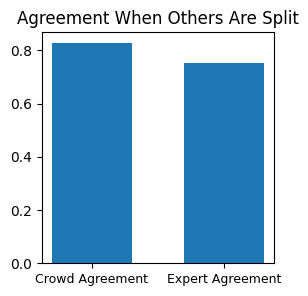

In [12]:
import matplotlib.pyplot as plt
expert_ties = reduced[reduced['Labeling State'] == 'In Progress']
crowd_ties = reduced[reduced['Crowd Agreement'] == 0.5]
crowd_agreement = np.mean(expert_ties['Crowd Agreement'])
expert_agreement = np.mean(crowd_ties['Expert Agreement'])
print(f'{len(crowd_ties)} instances of split crowd opinions')
print(f'{len(expert_ties)} instances of split expert opinions')
print(f'{np.mean(crowd_agreement)} crowd agreement when experts were split')
print(f'{np.mean(expert_agreement)} expert agreement when crowd was split')  
plt.figure(figsize=(3,3))
plt.bar(x = ['Crowd Agreement', 'Expert Agreement'], height = [crowd_agreement, expert_agreement], width = 0.6)
plt.title('Agreement When Others Are Split')
plt.xticks(fontsize=9)
plt.show()

- Crowd has split opinions less often
- Crowd is more confident when experts are split, than experts are when crowd is split

### Agreement with Expert Consensus

Crowd agrees with expert consensus 69.2% of the time
Experts agree with the expert consensus 77.8% of the time


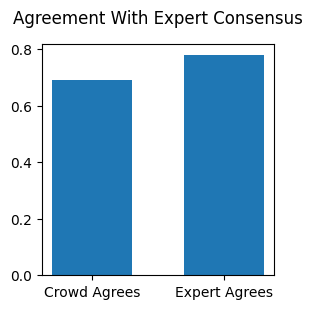

In [13]:
crowd_agree = sum(reduced['Consensus']=='yes')/len(reduced)
expert_agree = np.mean(reduced['Expert Agreement'])
print(f'Crowd agrees with expert consensus {round(crowd_agree*100,1)}% of the time')
print(f'Experts agree with the expert consensus {round(expert_agree*100,1)}% of the time')
plt.figure(figsize=(3,3))
plt.bar(['Crowd Agrees', 'Expert Agrees'], [crowd_agree, expert_agree], 0.6)
plt.title('Agreement With Expert Consensus', pad = 15)
plt.show()

This is not what we want, but could be affected by instances where the experts or crowd are undecided. Right now, these instances are marked as overall disagreements between the crowd and experts.

### Crowd Accuracy as a Function of Expert Agreement

{0.5: 0.8268833333333334, 0.625: 0.8594582069430401, 0.75: 0.8753985825177184, 0.875: 0.8863188771222053, 1.0: 0.9311936459909229}
{0.5: 0.0, 0.625: 0.6488333333333334, 0.75: 0.748, 0.875: 0.7991666666666667, 1.0: 0.9168333333333333}


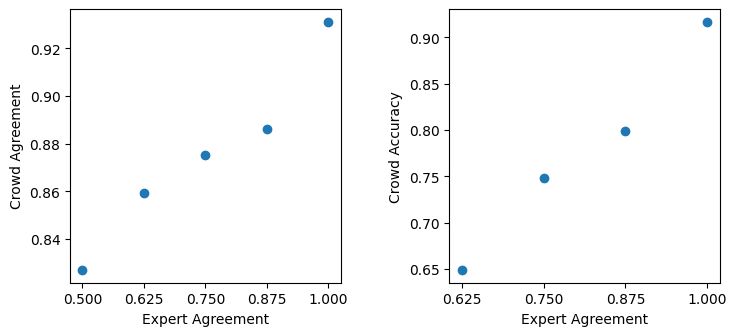

In [14]:
reduced
agreements = [4/8, 5/8, 6/8, 7/8, 8/8]
tracker = {}
y = {}
for val in agreements:
    idx = reduced['Expert Agreement'] == float(val)
    tracker[val] = np.mean(reduced[idx]['Crowd Agreement'])
    y[val] = sum(reduced[idx]['Correct Label'] == reduced[idx]['Majority Label'])/len(reduced[idx])
print(tracker)
print(y)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
ax1.set
ax1.scatter(tracker.keys(), tracker.values())
ax1.set_xlabel('Expert Agreement')
ax1.set_ylabel('Crowd Agreement')
ax1.set_xticks(list(y.keys()))
ax2.scatter(list(y.keys())[1:], list(y.values())[1:])
ax2.set_xlabel('Expert Agreement')
ax2.set_ylabel('Crowd Accuracy')
ax2.set_xticks(list(y.keys())[1:])
fig.tight_layout(pad=3)
plt.show()

**It is apparent that the crowd agreement and accuracy has a strong positive correlation with expert agreement**

### Importance of Difficulty

- **Find out who is most confident at different difficulty levels**
    - Split the data into quantiles based on difficulty
    - Analyze each quantile for both experts and the crowd
    - Compare confidence levels

In [15]:
diffs = list(reduced['Difficulty'].unique())
del diffs[1]
np.quantile(diffs,1/3)

idx_easy = reduced['Difficulty'] <= np.quantile(diffs,1/4)
idx_mod_easy1 = reduced['Difficulty'] <= np.quantile(diffs,1/2)
idx_mod_easy2 = reduced['Difficulty'] > np.quantile(diffs,1/4)
idx_mod_easy = idx_mod_easy1 * idx_mod_easy2
idx_mod_hard1 = reduced['Difficulty'] <= np.quantile(diffs,3/4)
idx_mod_hard2 = reduced['Difficulty'] > np.quantile(diffs,1/2)
idx_mod_hard = idx_mod_hard1 * idx_mod_hard2
idx_hard = reduced['Difficulty'] > np.quantile(diffs,3/4)

easy = reduced[idx_easy]
mod_easy = reduced[idx_mod_easy]
mod_hard = reduced[idx_mod_hard]
hard = reduced[idx_hard]

splits = {'Easy':easy, 'Mod. Easy': mod_easy, 'Mod. Difficult': mod_hard, 'Difficult':hard}

In [16]:
crowd = {}
experts = {}
for key, df in splits.items():
    expert_agreement = np.mean(df['Expert Agreement'])
    crowd_agreement = np.mean(df['Crowd Agreement'])
    experts[key] = expert_agreement
    crowd[key] = crowd_agreement
    print(f'Expert average agreement on {key} cases: {expert_agreement}')
    print(f'Crowd average agreement on {key} cases: {crowd_agreement}')

Expert average agreement on Easy cases: 0.839977944125117
Crowd average agreement on Easy cases: 0.9750197166154256
Expert average agreement on Mod. Easy cases: 0.793194640338505
Crowd average agreement on Mod. Easy cases: 0.6870567700987306
Expert average agreement on Mod. Difficult cases: 0.7691734921816828
Crowd average agreement on Mod. Difficult cases: 0.5629657483246462
Expert average agreement on Difficult cases: 0.7404932803909591
Crowd average agreement on Difficult cases: 0.9319349419670129


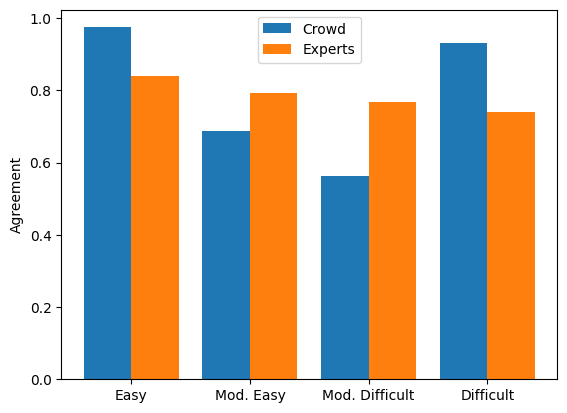

In [17]:
x = np.arange(4)
y1 = crowd.values()
y2 = experts.values()
width = 0.4
  
plt.bar(x-0.2, y1, width)
plt.bar(x+0.2, y2, width)
plt.xticks([0, 1, 2, 3],splits.keys())
plt.ylabel('Agreement')
plt.legend(['Crowd','Experts'])
plt.show()

**It appears the crowd has the advantage on the easiest and most difficult cases. The experts seem to have the advantage on the intermediate difficulty cases.**

### Crowd vs Experts Depending on Size of Crowd

- **Seperate the data based on qualified reads**
    - Look for a correlation in confidence based on number of reads
    - Compare confidence levels to experts

In [18]:
reads = reduced['Qualified Reads'].unique()

In [19]:
reads.sort()
tracker = {}
for num in reads[1:]:
    selected = reduced[reduced['Qualified Reads'] == num]
    tracker[num] = (np.mean(selected['Crowd Agreement']), np.mean(selected['Expert Agreement']))

In [20]:
tracker

{1: (1.0, 0.7907633242999097),
 2: (0.8742063492063492, 0.8009920634920635),
 3: (0.8837517730496454, 0.8054570527974784),
 4: (0.8728307414919991, 0.8047667342799188),
 5: (0.8764166470726547, 0.7946155654831883),
 6: (0.8787399831885682, 0.7902773886242646),
 7: (0.8800429184549357, 0.7700936402653141),
 8: (0.8777295632698768, 0.7338325867861142),
 9: (0.8745561497326203, 0.7042112299465241),
 10: (0.8706284153005464, 0.6613729508196722),
 11: (0.8533525179856115, 0.624400479616307),
 12: (0.8452666666666665, 0.6029761904761904),
 13: (0.8341538461538461, 0.5653846153846154),
 14: (0.8405892857142857, 0.5691964285714286),
 15: (0.8039393939393941, 0.5227272727272727),
 16: (0.7740769230769231, 0.5288461538461539),
 18: (0.8886666666666666, 0.5)}

**Now I will separate it into 3 groups: Small Crowd, Medium Crowd, and Big Crowd**

In [21]:
small_idx = reduced['Qualified Reads'] <= 6
medium_idx1 = reduced['Qualified Reads'] > 6
medium_idx2 = reduced['Qualified Reads'] <= 12
medium_idx = medium_idx1 * medium_idx2
big_idx = reduced['Qualified Reads'] > 12

small = reduced[small_idx]
medium = reduced[medium_idx]
big = reduced[big_idx]

splits = {'Small Crowd':small, 'Medium Crowd': medium, 'Big Crowd': big}

In [22]:
crowd = {}
experts = {}
for key, df in splits.items():
    expert_agreement = np.mean(df['Expert Agreement'])
    crowd_agreement = np.mean(df['Crowd Agreement'])
    experts[key] = expert_agreement
    crowd[key] = crowd_agreement
    print(f'Expert average agreement on {key} cases: {expert_agreement}')
    print(f'Crowd average agreement on {key} cases: {crowd_agreement}')

Expert average agreement on Small Crowd cases: 0.7987647353900176
Crowd average agreement on Small Crowd cases: 0.8841119179403849
Expert average agreement on Medium Crowd cases: 0.7241032210834554
Crowd average agreement on Medium Crowd cases: 0.8748288433382138
Expert average agreement on Big Crowd cases: 0.5574468085106383
Crowd average agreement on Big Crowd cases: 0.8288170212765957


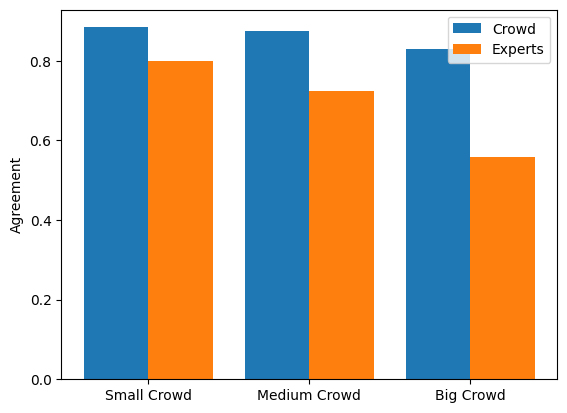

In [23]:
x = np.arange(3)
y1 = crowd.values()
y2 = experts.values()
width = 0.4
  
plt.bar(x-0.2, y1, width)
plt.bar(x+0.2, y2, width)
plt.xticks([0, 1, 2],splits.keys())
plt.ylabel('Agreement')
plt.legend(['Crowd','Experts'])
plt.show()

**It seems that the crowd is always more confident than the experts regardless of the crowd size. The biggest separation between the crowd confidence and experts confidence is when there are a high number of qualified reads.**

---
# Descriptive Analysis

## (Part 2)

### Data Cleaning and Merging

In [24]:
results_red = reduced[reduced['Labeling State'] == 'Gold Standard']
reads = pd.read_csv('data/1345_admin_reads.csv')
reads = reads[reads['labeling_state'] == 'gold_standard']
reads_red = reads[['problem_id', 'user_id', 'accuracy','chosen_answer']]

# match the indices
reads_red.set_index('problem_id',inplace=True)

In [25]:
# Merge and Filter
merged = pd.merge(results_red, reads_red, how='left', left_index=True, right_index=True)
merged.index.name = 'problem_id'
merged = merged[merged['Labeling State'] == 'Gold Standard']
isolated = merged[['user_id','accuracy','chosen_answer','Correct Label']]
isolated.head(2)

,user_id,accuracy,chosen_answer,Correct Label
problem_id,,,,
5888087,55058.0,0.78,['no'],'no'
5888087,248277.0,0.76,['no'],'no'


### Creating the Problem X User Matrix

In [26]:
Xdf = merged.pivot_table(values='accuracy', index = 'problem_id', columns='user_id')
idx = Xdf.index.unique().tolist()
Xdf.replace(np.nan,0, inplace=True)
Xdf.head(2)

user_id,1196.0,1858.0,2581.0,2815.0,2861.0,7280.0,11697.0,11715.0,15245.0,19769.0,21682.0,30879.0,32053.0,37193.0,38179.0,41816.0,42266.0,43096.0,44164.0,44512.0,44529.0,45825.0,46115.0,46403.0,46967.0,47705.0,48054.0,48437.0,48870.0,49472.0,49560.0,50205.0,50342.0,50420.0,51197.0,52355.0,52785.0,52882.0,52979.0,53036.0,53129.0,53717.0,53744.0,53789.0,54178.0,54870.0,54890.0,55058.0,55188.0,55386.0,55411.0,55422.0,55602.0,55669.0,55672.0,56746.0,56959.0,57188.0,57507.0,57749.0,57851.0,62640.0,62945.0,63450.0,63821.0,64460.0,64472.0,64485.0,64513.0,64625.0,64667.0,64701.0,64885.0,65046.0,65094.0,65129.0,65244.0,65368.0,65588.0,65621.0,65699.0,65854.0,66136.0,66589.0,66654.0,67217.0,67350.0,67615.0,67879.0,68333.0,68409.0,68904.0,69061.0,69599.0,71806.0,71885.0,78505.0,80367.0,84307.0,84759.0,87206.0,90170.0,94530.0,98931.0,99033.0,99146.0,99820.0,100457.0,101978.0,102375.0,102777.0,103017.0,103139.0,104231.0,104357.0,104694.0,105321.0,105711.0,107650.0,110433.0,112839.0,113465.0,114283.0,114389.0,114957.0,115065.0,115071.0,115088.0,115094.0,115125.0,115295.0,116576.0,117044.0,118059.0,118064.0,119391.0,119656.0,119850.0,119939.0,120668.0,120988.0,121394.0,121612.0,121909.0,122607.0,122901.0,122904.0,123160.0,123180.0,123392.0,123754.0,125048.0,125362.0,126201.0,126656.0,126914.0,127786.0,127794.0,127883.0,128538.0,128820.0,128872.0,129198.0,129201.0,129700.0,130025.0,130084.0,130230.0,130485.0,130547.0,130766.0,130904.0,130928.0,130978.0,131059.0,131174.0,131314.0,131544.0,131744.0,131793.0,131906.0,131945.0,132095.0,132224.0,132272.0,132433.0,132459.0,132541.0,133064.0,133614.0,133630.0,133646.0,133738.0,133739.0,134015.0,134181.0,134321.0,134562.0,134865.0,135031.0,135477.0,136027.0,136162.0,136644.0,136672.0,136932.0,137179.0,137347.0,137392.0,137488.0,137730.0,137759.0,137868.0,137983.0,138291.0,138292.0,138317.0,138467.0,138471.0,138570.0,138685.0,138985.0,139001.0,139140.0,139514.0,139516.0,139696.0,139736.0,139763.0,139917.0,140211.0,140537.0,140647.0,141324.0,141335.0,141601.0,141655.0,141668.0,141924.0,141983.0,142175.0,142217.0,142399.0,142622.0,142690.0,142774.0,143035.0,143074.0,143164.0,143178.0,143270.0,143344.0,143397.0,143541.0,143562.0,143792.0,143831.0,144146.0,144712.0,144910.0,145041.0,145203.0,145216.0,145318.0,145323.0,145348.0,145527.0,145576.0,145590.0,145621.0,145848.0,145853.0,145876.0,145986.0,146383.0,146384.0,146604.0,146708.0,146852.0,146881.0,146897.0,146904.0,147009.0,147030.0,147056.0,147231.0,147290.0,147346.0,147367.0,147428.0,147480.0,147591.0,147639.0,147652.0,147719.0,147720.0,147736.0,147811.0,147908.0,148036.0,148136.0,148159.0,148215.0,148343.0,148351.0,148435.0,148452.0,148457.0,148499.0,148514.0,148605.0,148701.0,148717.0,148723.0,148919.0,149136.0,149304.0,149372.0,149394.0,149421.0,149478.0,149527.0,149558.0,149594.0,149966.0,150045.0,150226.0,150294.0,150306.0,150307.0,150352.0,150355.0,150503.0,150586.0,150726.0,150761.0,150843.0,150851.0,150964.0,151012.0,151016.0,151102.0,151181.0,151212.0,151239.0,151333.0,151343.0,151355.0,151371.0,151417.0,151458.0,151463.0,151475.0,151518.0,151530.0,151536.0,151565.0,151630.0,151635.0,151662.0,151671.0,151723.0,151821.0,152032.0,152093.0,152094.0,152115.0,152121.0,152176.0,152212.0,152336.0,152364.0,152715.0,152722.0,152765.0,152783.0,152809.0,152839.0,152869.0,153066.0,153109.0,153145.0,153157.0,153194.0,153289.0,153551.0,153607.0,153657.0,153797.0,153868.0,153874.0,153967.0,154019.0,154310.0,154370.0,154461.0,154836.0,155260.0,155448.0,155858.0,156193.0,157004.0,157174.0,157186.0,157264.0,157446.0,157471.0,158405.0,158671.0,158731.0,158831.0,158906.0,158939.0,159195.0,159613.0,159962.0,160323.0,160364.0,160389.0,160608.0,160728.0,161391.0,161516.0,162086.0,162225.0,162782.0,163989.0,164722.0,165055.0,165245.0,166153.0,166554.0,167374.0,167384.0,167565.0,167599.0,168012.0,168231.0,168252.0,168462.0,168708.0,168886.0,169037.0,169047.0,169073.0,169118.0,169241.0,169281.0,169299.0,169322.0,169425.0,169435.0,169995.0,170129.0,170143.0,170325.0,1

In [27]:
y = results_red.loc[idx]['Correct Label'].values

### Feature Selection 

- **Using Random Forest Gini Importance**
- Creating a ranking of the most important users



In [28]:
from sklearn.ensemble import RandomForestClassifier

feature_names = Xdf.columns.tolist()
forest = RandomForestClassifier(random_state=0)
forest.fit(Xdf, y)

RandomForestClassifier(random_state=0)

In [29]:
# Ranking the best users
importances = forest.feature_importances_.tolist()
top_scores = [importances.pop(np.argmax(importances)) for i in range(len(importances))]
importances = forest.feature_importances_.tolist()
top_idx = [importances.index(score) for score in top_scores]

best_users = [Xdf.columns[val] for val in top_idx]
best10_users = [Xdf.columns[val] for val in top_idx[:10]]
#importances

In [30]:
# Ranking the worst users
importances = forest.feature_importances_.tolist()
worst_scores = [importances.pop(np.argmin(importances)) for i in range(len(importances))]
importances = forest.feature_importances_.tolist()
worst_idx = [importances.index(score) for score in worst_scores]

worst_users = [Xdf.columns[val] for val in worst_idx]
worst10_users = [Xdf.columns[val] for val in worst_idx[:10]]

In [31]:
# Make sure it worked properly
print(np.mean(np.unique(Xdf[worst_users[0]].values)))
np.mean(np.unique(Xdf[best_users[0]].values))

0.375


0.819375

In [32]:
best10_users

[19769.0,
 245612.0,
 118064.0,
 1196.0,
 123180.0,
 130978.0,
 184941.0,
 143270.0,
 134562.0,
 131544.0]

In [33]:
worst10_users

[275406.0,
 137730.0,
 157471.0,
 232973.0,
 152115.0,
 264827.0,
 231968.0,
 269791.0,
 256126.0,
 256225.0]

### A New Aggregation Technique

- **Only use high ranked users' input**
    - See if the higher ranked half of qualified reads agree
        - This will be the new label
    - Use majority if higher ranked half is split
    
**This should cut the number of users needed almost in half.**

In [34]:
# Adding rankings to DataFrame
indices = isolated.index.unique()
isolated['ranking'] = ''
for idx in indices:
    try:
        if len(isolated.loc[[idx]]) > 1:
            for i in range(len(isolated.loc[idx])):
                isolated.loc[idx, 'ranking'].iloc[i] = best_users.index(isolated.loc[idx, 'user_id'].iloc[i]) + 1
        else:
            isolated.loc[idx, 'ranking'] = best_users.index(isolated.loc[idx]['user_id'])
    except:
        continue

In [35]:
isolated

,user_id,accuracy,chosen_answer,Correct Label,ranking
problem_id,,,,,
5888087,55058.0,0.78,['no'],'no',42
5888087,248277.0,0.76,['no'],'no',38
5888088,19769.0,0.78,['no'],'no',1
5888088,237039.0,0.80,['no'],'no',571
5888088,280445.0,0.76,['no'],'no',119
...,...,...,...,...,...
5918379,19769.0,0.82,['yes'],'yes',1
5918379,53129.0,0.78,['yes'],'yes',246
5918379,102777.0,0.84,['yes'],'yes',14


In [36]:
iso_clean = isolated.dropna(axis=0)
iso_clean.sort_values(['problem_id', 'ranking'], inplace=True)
filtered = reduced[reduced['Labeling State'] == 'Gold Standard']
iso_clean

,user_id,accuracy,chosen_answer,Correct Label,ranking
problem_id,,,,,
5888087,248277.0,0.76,['no'],'no',38
5888087,55058.0,0.78,['no'],'no',42
5888088,19769.0,0.78,['no'],'no',1
5888088,280445.0,0.76,['no'],'no',119
5888088,237039.0,0.80,['no'],'no',571
...,...,...,...,...,...
5918379,19769.0,0.82,['yes'],'yes',1
5918379,102777.0,0.84,['yes'],'yes',14
5918379,250601.0,0.76,['no'],'yes',77


In [37]:
filtered['Adjusted Label'] = '?'
total_viewers = 0
for prob_id in iso_clean.index.unique():
    if len(iso_clean.loc[[prob_id]]) > 1:
        yes_votes = 0
        for i in range(len(iso_clean.loc[prob_id])//2):
            yes_votes += iso_clean.loc[prob_id,'chosen_answer'].iloc[i] == "['yes']"
        if yes_votes > (len(iso_clean.loc[prob_id])//2)//2:
            total_viewers += i + 1
            filtered.loc[prob_id, 'Adjusted Label'] = "'yes'"
        elif yes_votes < (len(iso_clean.loc[prob_id])//2)//2:
            total_viewers += i + 1
            filtered.loc[prob_id, 'Adjusted Label'] = "'no'"
        else:
            total_viewers += reduced.loc[prob_id, 'Qualified Reads']
            filtered.loc[prob_id, 'Adjusted Label'] = reduced.loc[prob_id, 'Majority Label']
    else:
        filtered.loc[prob_id, 'Adjusted Label'] = filtered.loc[prob_id, 'Majority Label']
        total_viewers += 1

In [38]:
filtered = filtered[filtered['Qualified Reads'] > 0]
filtered.head(5)

,Labeling State,Qualified Reads,Correct Label,Majority Label,Difficulty,Crowd Agreement,First Choice Weight,Second Choice Weight,N Expert Affirmation,Expert Agreement,Consensus,Adjusted Label
Case ID,,,,,,,,,,,,
5888087,Gold Standard,2,'no','no',0.0,1.0,1.54,0.0,2,0.75,yes,'no'
5888088,Gold Standard,3,'no','no',0.0,1.0,2.34,0.0,0,1.0,yes,'no'
5888089,Gold Standard,2,'no','no',0.0,1.0,1.70,0.0,0,1.0,yes,'no'
5888090,Gold Standard,1,'no','no',0.0,1.0,0.82,0.0,0,1.0,yes,'no'
5888092,Gold Standard,4,'no','no',0.0,1.0,3.30,0.0,0,1.0,yes,'no'


In [39]:
original = reduced[reduced['Labeling State'] == 'Gold Standard'] 
original = original[original['Qualified Reads'] > 0]
#original

**How accurate is the new strategy in comparison to majority vote aggregation?**

In [40]:
print(sum(filtered['Qualified Reads']))
full_crowd = sum(filtered['Qualified Reads'])
crowd = sum(filtered['Majority Label'] == filtered['Correct Label'])/len(filtered)
crowd

112832


0.7861351965653675

In [41]:
#print(total_viewers)
adjusted = sum(filtered['Adjusted Label'] == filtered['Correct Label'])/len(filtered)
print(f'Adjusted label accuracy with {total_viewers} viewers: {round(adjusted, 3)}')
print(f'This is {round(total_viewers/full_crowd,3)} the original viewer count')

Adjusted label accuracy with 63685 viewers: 0.783
This is 0.564 the original viewer count


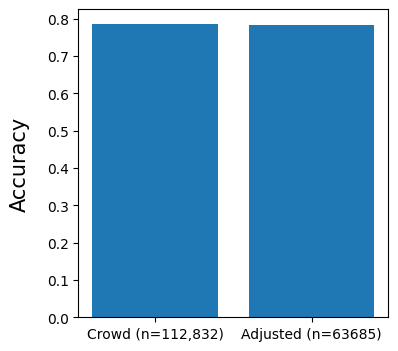

In [42]:
plt.figure(figsize=(4,4))
plt.bar(['Crowd (n=112,832)',f'Adjusted (n={total_viewers})'],[crowd, adjusted])
plt.ylabel('Accuracy',fontsize=15,labelpad=12)
plt.show()

- **The amount of qualified reads can be almost cut in half with minimal sacrifice**
    - This would majorly reduce expenses
    - Crowd will incorrectly label 1 more image for every ~300
- Maybe a weighted aggregation system that uses all users' inputs could improve this accuracy further

### Trying a Weighted Vote Aggregation

- **Weight the users' votes based on ranking**
    - Take the reciprocal of the users' rankings
    - Take the zscore of the reciprocal with mean=0
    - The zscore is the weight of their vote

In [43]:
# Adding weighted votes to DataFrame
indices = isolated.index.unique()
filtered['Zweight'] = 0
s = np.std([1/(n[0]+1) for n in enumerate(best_users)])
for idx in indices:
    try:
        if len(isolated.loc[[idx]]) > 1:
            for i in range(len(isolated.loc[idx])):
                ranking = best_users.index(isolated.loc[idx, 'user_id'].iloc[i]) + 1
                if isolated.loc[idx, 'chosen_answer'].iloc[i] == "['no']":     
                    filtered.loc[idx, 'Zweight'] -= (ranking/s)
                else:
                    filtered.loc[idx, 'Zweight'] += (ranking/s)
        else:
            ranking = best_users.index(isolated.loc[idx, 'user_id']) + 1
            if isolated.loc[idx, 'chosen_answer'] == "['no']":
                filtered.loc[idx, 'Zweight'] -= (ranking/s)
            else:
                filtered.loc[idx, 'Zweight'] += (ranking/s)
    except:
        continue

In [44]:
zyes_idx = filtered['Zweight'] > 0
zno_idx = filtered['Zweight'] < 0
zsplit_idx = filtered['Zweight'] == 0
filtered['Zlabel'] = '?'
filtered.loc[zsplit_idx, 'Zlabel'] = filtered.loc[zsplit_idx,'Majority Label']
filtered.loc[zyes_idx, 'Zlabel'] = "'yes'"
filtered.loc[zno_idx, 'Zlabel'] = "'no'"

In [45]:
filtered.head(3)

,Labeling State,Qualified Reads,Correct Label,Majority Label,Difficulty,Crowd Agreement,First Choice Weight,Second Choice Weight,N Expert Affirmation,Expert Agreement,Consensus,Adjusted Label,Zweight,Zlabel
Case ID,,,,,,,,,,,,,,
5888087,Gold Standard,2,'no','no',0.0,1.0,1.54,0.0,2,0.75,yes,'no',-2033.815312,'no'
5888088,Gold Standard,3,'no','no',0.0,1.0,2.34,0.0,0,1.0,yes,'no',-17567.079761,'no'
5888089,Gold Standard,2,'no','no',0.0,1.0,1.70,0.0,0,1.0,yes,'no',-3813.403711,'no'


**Let's see how accurate the weighted choices are...**

In [46]:
sum(filtered['Correct Label'] == filtered['Zlabel'])/len(filtered)

0.74757976260628

That is worse than the majority label accuracy we saw earlier.

### Using the Weighted Votes to Train a Logistic Regression Model

In [47]:
from sklearn.linear_model import LogisticRegression as LR
X = filtered['Zweight'].values
y = filtered['Correct Label'].values
model = LR()

model.fit(X.reshape(-1,1),y)
acc = model.score(X.reshape(-1,1),y)
acc

0.7476639447764963

**This is a significant improvement in accuracy.**

But is the model overfit?

In [48]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=10, shuffle = True)

test_acc = []
for idxtrain, idxtest in kf.split(X.reshape(-1,1),y):
    xtrain = X[idxtrain]
    xtest = X[idxtest]
    ytrain = y[idxtrain]
    ytest = y[idxtest]
    model = LR(max_iter=200) 
    model.fit(xtrain.reshape(-1,1),ytrain)
    test_acc.append(model.score(xtest.reshape(-1,1),ytest))
np.mean(test_acc)

0.7476640616693249

**According to a 10-fold KFold cross validation, the logistic regression model is NOT overfit.**

**Now the crowd is MUCH more accurate than individual experts.**

Crowd agrees with expert consensus 74.8% of the time
Experts agree with the expert consensus 81.3% of the time


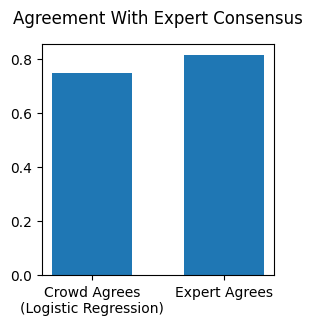

In [49]:
crowd_agree = acc
expert_agree = np.mean(filtered['Expert Agreement'])
print(f'Crowd agrees with expert consensus {round(crowd_agree*100,1)}% of the time')
print(f'Experts agree with the expert consensus {round(expert_agree*100,1)}% of the time')
plt.figure(figsize=(3,3))
plt.bar(['Crowd Agrees\n(Logistic Regression)', 'Expert Agrees'], [crowd_agree, expert_agree], 0.6)
plt.title('Agreement With Expert Consensus', pad = 15)
plt.show()

### Using DESlib

In [73]:
from sklearn.model_selection import train_test_split
from deslib.des import METADES
from deslib.des import KNORAE

rng = np.random.RandomState(42)

X, y = Xdf, y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33,
                                                    random_state=rng)

X_train, X_dsel, y_train, y_dsel = train_test_split(X_train, y_train,
                                                    test_size=0.5,
                                                    random_state=rng)

kne = KNORAE(random_state=rng)
meta = METADES(random_state=rng)

kne.fit(X_dsel, y_dsel)
meta.fit(X_dsel, y_dsel)

print('Classification accuracy KNORA-Eliminate: ',
      kne.score(X_test, y_test))
print('Classification accuracy META-DES: ', meta.score(X_test, y_test))

Classification accuracy KNORA-Eliminate:  0.53028950388981
Classification accuracy META-DES:  0.5276112740721847


**Not sure if I did this properly, but these are not the results we want.**

### Attempting ELICE

In [51]:
filtered.head(3)

,Labeling State,Qualified Reads,Correct Label,Majority Label,Difficulty,Crowd Agreement,First Choice Weight,Second Choice Weight,N Expert Affirmation,Expert Agreement,Consensus,Adjusted Label,Zweight,Zlabel
Case ID,,,,,,,,,,,,,,
5888087,Gold Standard,2,'no','no',0.0,1.0,1.54,0.0,2,0.75,yes,'no',-2033.815312,'no'
5888088,Gold Standard,3,'no','no',0.0,1.0,2.34,0.0,0,1.0,yes,'no',-17567.079761,'no'
5888089,Gold Standard,2,'no','no',0.0,1.0,1.70,0.0,0,1.0,yes,'no',-3813.403711,'no'


In [52]:
iso_clean.head(4)
iso_clean.dropna(axis=0, subset='chosen_answer', inplace=True)
iso_clean['chosen_answer'].str.split("'",0)
answers = []
for i in range(len(iso_clean)):
    answers.append("'" + iso_clean.iloc[i]['chosen_answer'].split("'")[1].split("'")[0] + "'")

In [53]:
iso_clean['chosen_answer'] = answers
iso_clean.head()


,user_id,accuracy,chosen_answer,Correct Label,ranking
problem_id,,,,,
5888087,248277.0,0.76,'no','no',38
5888087,55058.0,0.78,'no','no',42
5888088,19769.0,0.78,'no','no',1
5888088,280445.0,0.76,'no','no',119
5888088,237039.0,0.80,'no','no',571


In [54]:
len(isolated['user_id'].unique())

1028

In [55]:
# Creating alpha values
iso_clean['alpha'] = 0
for j in iso_clean['user_id'].unique():
    j_subset = iso_clean[iso_clean['user_id'] == j]
    raw_score = 0
    for i in range(len(j_subset)):
        correct = j_subset.iloc[i]['chosen_answer'] == j_subset.iloc[i]['Correct Label']
        incorrect = j_subset.iloc[i]['chosen_answer'] != j_subset.iloc[i]['Correct Label']
        raw_score += ((1*correct) - (1*incorrect))
    alpha = raw_score/len(j_subset)
    user_idx = iso_clean['user_id'] == j
    iso_clean.loc[user_idx,'alpha'] = alpha

In [56]:
alphas = iso_clean[['user_id', 'alpha']]
alphas.drop_duplicates(subset='user_id', inplace=True)

In [57]:
alphas.head(2)

,user_id,alpha
problem_id,,
5888087,248277.0,0.544974
5888087,55058.0,0.550756


In [58]:
iso_clean.head(2)

,user_id,accuracy,chosen_answer,Correct Label,ranking,alpha
problem_id,,,,,,
5888087,248277.0,0.76,'no','no',38,0.544974
5888087,55058.0,0.78,'no','no',42,0.550756


In [59]:
filtered.head(2)

,Labeling State,Qualified Reads,Correct Label,Majority Label,Difficulty,Crowd Agreement,First Choice Weight,Second Choice Weight,N Expert Affirmation,Expert Agreement,Consensus,Adjusted Label,Zweight,Zlabel
Case ID,,,,,,,,,,,,,,
5888087,Gold Standard,2,'no','no',0.0,1.0,1.54,0.0,2,0.75,yes,'no',-2033.815312,'no'
5888088,Gold Standard,3,'no','no',0.0,1.0,2.34,0.0,0,1.0,yes,'no',-17567.079761,'no'


In [81]:
filtered['ELICE Expected'] = ''
filtered['ELICE si'] = ''
for i in iso_clean.index.unique():
    raw_label = 0
    for j in range(len(iso_clean.loc[[i]])):
        if iso_clean.loc[[i]].iloc[j]['chosen_answer'] == "'no'":
            raw_label += (-1 * iso_clean.loc[[i]].iloc[j]['alpha'])
        else:
            raw_label += (1 * iso_clean.loc[[i]].iloc[j]['alpha'])
    label = raw_label/len(iso_clean.loc[i])
    filtered.loc[i, 'ELICE si'] = label
    if label >= 0:
        filtered.loc[i, 'ELICE Expected'] = "'yes'"
    else:
        filtered.loc[i, 'ELICE Expected'] = "'no'"

In [61]:
filtered.dropna(subset='Majority Label', inplace=True)
min(filtered['ELICE si'])

-0.8516431924882629

In [62]:
sum(filtered['ELICE Expected'] == filtered['Correct Label'])/len(filtered)
#sum(filtered['Majority Label'] == filtered['Correct Label'])/len(filtered)

0.7910598535230238

In [63]:
from sklearn.linear_model import LogisticRegression as LR
X = filtered['ELICE si'].values
y = filtered['Correct Label'].values
model = LR()

model.fit(X.reshape(-1,1),y)
acc = model.score(X.reshape(-1,1),y)
acc

0.7937115918848388

In [64]:
# adjusting difficulties to match ELICE
filtered['Difficulty'] = (filtered['Difficulty'] - 1) * -1
filtered.head(2)

,Labeling State,Qualified Reads,Correct Label,Majority Label,Difficulty,Crowd Agreement,First Choice Weight,Second Choice Weight,N Expert Affirmation,Expert Agreement,Consensus,Adjusted Label,Zweight,Zlabel,ELICE Expected,ELICE si
Case ID,,,,,,,,,,,,,,,,
5888087,Gold Standard,2,'no','no',1.0,1.0,1.54,0.0,2,0.75,yes,'no',-2033.815312,'no','no',-0.547865
5888088,Gold Standard,3,'no','no',1.0,1.0,2.34,0.0,0,1.0,yes,'no',-17567.079761,'no','no',-0.574886


In [65]:
import math
filtered['ELICE Inferred'] = ''
for i in iso_clean.index.unique():
    raw_label = 0
    beta = filtered.loc[i]['Difficulty'].astype(int)
    for j in range(len(iso_clean.loc[[i]])):
        alpha = iso_clean.loc[[i]].iloc[j]['alpha']
        if iso_clean.loc[[i]].iloc[j]['chosen_answer'] == "'no'":
            raw_label += (-1 * (1/(math.exp(-alpha*beta))))
        else:
            raw_label += (1 * (1/(math.exp(-alpha*beta))))
    label = raw_label/len(iso_clean.loc[i])
    if label >= 0:
        filtered.loc[i, 'ELICE Inferred'] = "'yes'"
    else:
        filtered.loc[i, 'ELICE Inferred'] = "'no'"

In [66]:
sum(filtered['ELICE Inferred'] == filtered['Correct Label'])/len(filtered)

0.7777169795437326

In [67]:
from sklearn.preprocessing import StandardScaler as SS

# Descriptive Analysis
## Part 3- Making Ensembled Predictions

In [68]:
X = filtered[['Majority Label']]
X = pd.get_dummies(X)
X[['Zweight', 'ELICE si']] = filtered[['Zweight', 'ELICE si']]

In [69]:
scaler = SS()
Xs = scaler.fit_transform(X)

In [70]:
model = LR()

model.fit(Xs,y)
acc = model.score(Xs,y)
acc

0.7929118612677835

In [84]:
filtered['ELICE si'] = filtered['ELICE si'].astype(float)
filtered.head(2)

,Labeling State,Qualified Reads,Correct Label,Majority Label,Difficulty,Crowd Agreement,First Choice Weight,Second Choice Weight,N Expert Affirmation,Expert Agreement,Consensus,Adjusted Label,Zweight,Zlabel,ELICE Expected,ELICE si,ELICE Inferred
Case ID,,,,,,,,,,,,,,,,,
5888087,Gold Standard,2,'no','no',1.0,1.0,1.54,0.0,2,0.75,yes,'no',-2033.815312,'no','no',-0.547865,'no'
5888088,Gold Standard,3,'no','no',1.0,1.0,2.34,0.0,0,1.0,yes,'no',-17567.079761,'no','no',-0.574886,'no'


In [79]:
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.linear_model import LogisticRegression as LR

In [158]:
X_ = filtered[['Qualified Reads', 'Majority Label', 'Difficulty', 'First Choice Weight', 'Second Choice Weight', 'Zweight', 'ELICE si', 'ELICE Inferred']]
X_df = pd.get_dummies(X_df)
X = X_df.values
y = filtered['Correct Label'].values

In [159]:
log = LR()

model.fit(X,y)
acc = model.score(X,y)
acc

0.7961949659062211

In [153]:
def DoKFold(model,X,y,k=5,scaler=None,random_state=146):
    from sklearn.model_selection import KFold
    import pandas as pd
    
    kf = KFold(n_splits=k, shuffle=True, random_state=random_state)

    # As we're doing the k fold validation, we'll keep track of training and testing scores
    train=[]
    test=[]

    # Make sure X is an array
    if type(X) == pd.core.frame.DataFrame:
        X = X.values

    for idxTrain,idxTest in kf.split(X):
        Xtrain = X[idxTrain,:]
        Xtest = X[idxTest,:]
        ytrain = y[idxTrain]
        ytest = y[idxTest]

        # If we want to rescale the data in any way, that should happen now:
        if scaler is not None:
            Xtrain = scaler.fit_transform(Xtrain)
            Xtest = scaler.transform(Xtest)
        # Now fit the model on the training data
        model.fit(Xtrain, ytrain)

        # Record the scores
        train.append(model.score(Xtrain,ytrain))
        test.append(model.score(Xtest,ytest))
        
    return train, test

In [154]:
DoKFold(log,X,y)

([0.7853835630853415,
  0.7478164790066295,
  0.7850678733031674,
  0.7495659493870679,
  0.8162782132898406],
 [0.7904040404040404,
  0.7466329966329966,
  0.7920875420875421,
  0.7396337613134077,
  0.8143548726583877])

In [108]:
n_trees = [5,6,7]
max_depth_range = np.arange(1,6)
k = 20

train = []
test = []

x_axis = []
for d in max_depth_range:
    for n in n_trees:
        rfc = RFC(n_estimators=n,
                  max_depth=d,
                  max_features=None, 
                  random_state=146)
        tr,te = DoKFold(rfc,X,y,k,SS())

        train.append(np.mean(tr))
        test.append(np.mean(te))
        x_axis.append('MD' + str(d) + ' ; ' + str(n) + 'Tr')

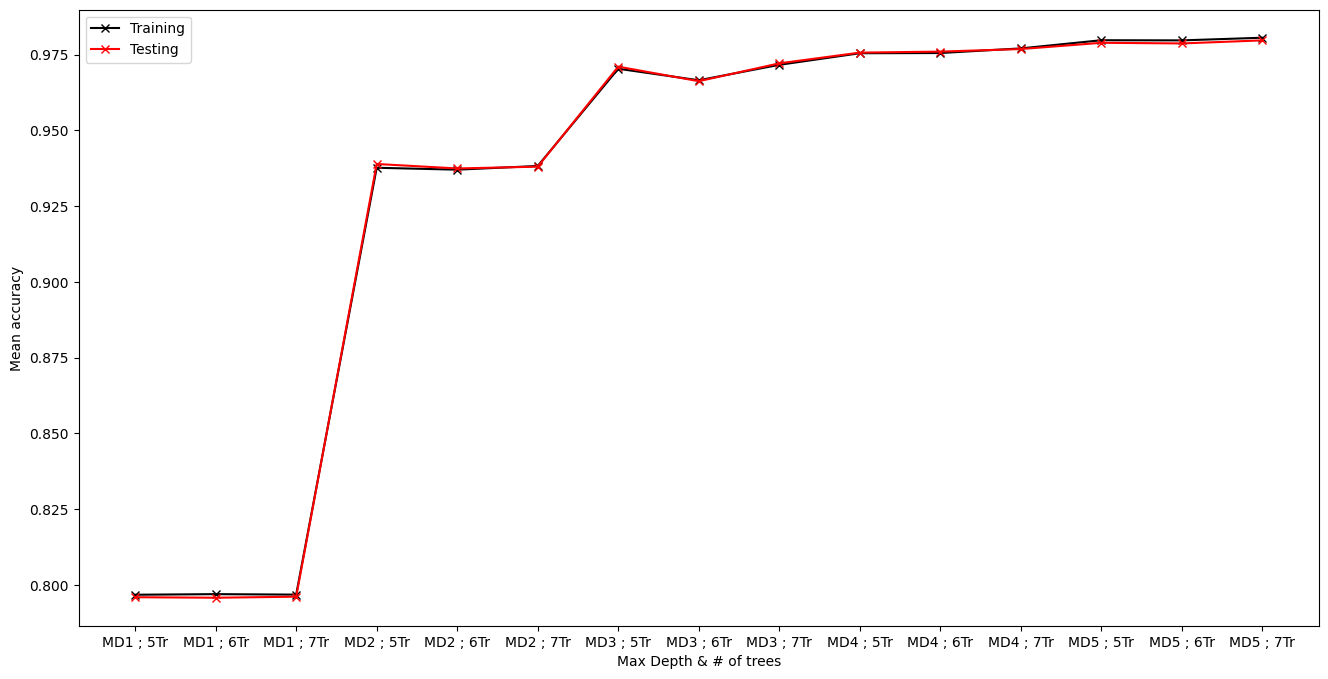

In [110]:
plt.figure(figsize=(16,8))
plt.plot(x_axis, train, '-xk', label='Training')
plt.plot(x_axis, test, '-xr', label='Testing')
plt.xlabel('Max Depth & # of trees')
plt.ylabel('Mean accuracy')
plt.legend()
plt.show()

In [111]:
rfc = RFC(n_estimators=5,
                  max_depth=3,
                  max_features=None, 
                  random_state=146)
tr,te = DoKFold(rfc,X,y,10)

In [112]:
tr,te

([0.9707230380694042,
  0.9731549901786549,
  0.9713310260967168,
  0.9754466373585259,
  0.9714245627163034,
  0.9571134599195585,
  0.9741371246843139,
  0.9774109063698438,
  0.9722676892858813,
  0.9721741570406398],
 [0.9659090909090909,
  0.9705387205387206,
  0.9713804713804713,
  0.9747474747474747,
  0.9751683501683501,
  0.9553872053872053,
  0.9747474747474747,
  0.9789562289562289,
  0.9717894736842105,
  0.9705263157894737])

In [142]:
Xt = X[:12000]
yt = y[:12000]
rfc = RFC(n_estimators=5,
                  max_depth=3,
                  max_features=None, 
                  random_state=146)
rfc.fit(Xt,yt)
ypred = rfc.predict(X)

In [143]:
sum(y == ypred)/len(y)

0.9445239498274266

In [119]:
ypred

array([[0.99833401, 0.00166599],
       [0.99833401, 0.00166599],
       [0.99833401, 0.00166599],
       ...,
       [1.        , 0.        ],
       [0.72241304, 0.27758696],
       [0.        , 1.        ]])

In [160]:
feature_importances = pd.DataFrame(rfc.feature_importances_,
                                index = X_df.columns,
                                columns=['importance']).sort_values('importance', 
                                             ascending=False)

print(feature_importances)

                      importance
ELICE si                0.500988
Difficulty              0.446089
ELICE Inferred_'yes'    0.026827
Majority Label_'yes'    0.026096
Qualified Reads         0.000000
First Choice Weight     0.000000
Second Choice Weight    0.000000
Zweight                 0.000000
Majority Label_'no'     0.000000
ELICE Inferred_'no'     0.000000


In [164]:
# Can I bring up the accuracy by filtering useful variables

In [162]:
X_reduced = X_df[['ELICE si', 'Difficulty',"ELICE Inferred_'yes'", "Majority Label_'yes'"]].values

In [163]:
log = LR()

model.fit(X_reduced,y)
acc = model.score(X_reduced,y)
acc

0.8200185200774476

In [167]:
tr, te = DoKFold(log,X_reduced,y)
np.mean(tr), np.mean(te)

(0.8197027960716146, 0.8199340720046887)

In [168]:
### Let's Try Decision Tree

In [171]:
max_depth_range = np.arange(5,10)

# Keep track of training and testing scores
train=[]
test=[]
for d in max_depth_range:
    dtc = DTC(max_depth=d, random_state=146)
    tr,te = DoKFold(dtc,X,y)
    
    train.append(np.mean(tr))
    test.append(np.mean(te))

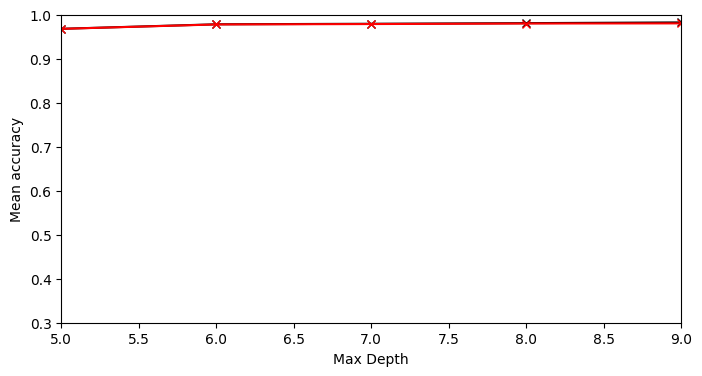

In [173]:
plt.figure(figsize=(8,4))
plt.plot(max_depth_range, train, '-kx', label='Training')
plt.plot(max_depth_range, test, '-rx', label='Testing')
plt.xlabel('Max Depth')
plt.ylabel('Mean accuracy')
plt.xlim([5,9])
plt.ylim([.3,1])
plt.show()

In [187]:
dtc = DTC(max_depth = 5, random_state=146)
dtc.fit(X,y)
dtc.score(X,y)

0.9594241939557202

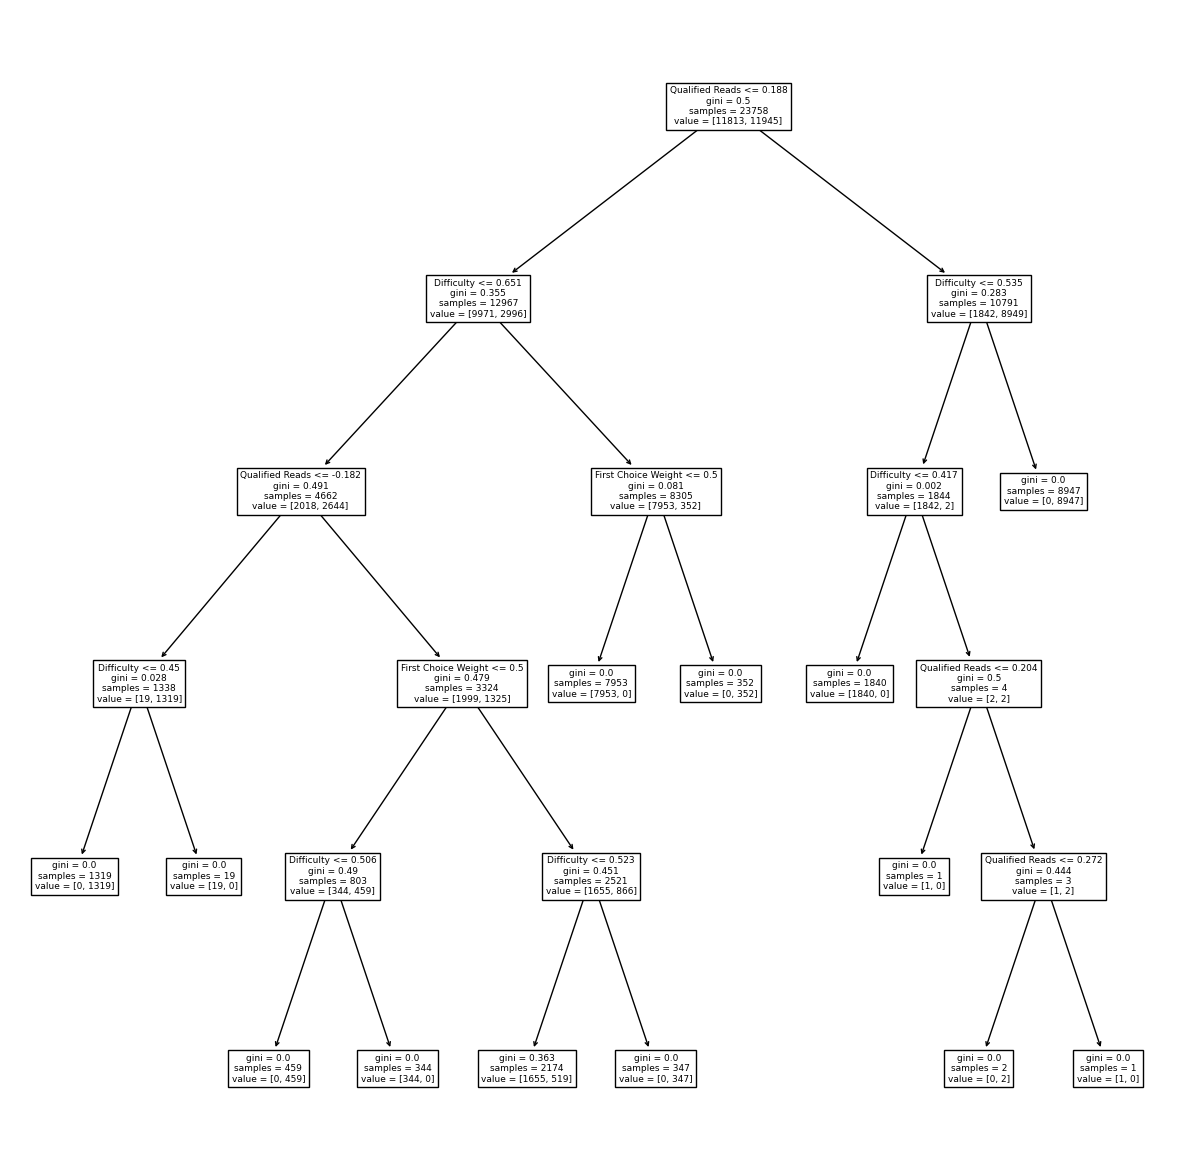

In [184]:
from sklearn import tree
plt.figure(figsize=(15,15))
tree.plot_tree(dtc, feature_names=X_df.columns)
plt.show()

In [188]:
### Now let's try KNN

In [311]:
# To find a suitable value for k, run a bunch of tests
k_range = np.arange(98,103,1)

# Keep track of overall accuracy
train=[]
test=[]

for k in k_range:
    print('Testing k=', k)
    knn = KNN(n_neighbors=k)
    tr,te = DoKFold(knn,X_reduced,y)
    
    train.append(np.mean(tr))
    test.append(np.mean(te))

Testing k= 98
Testing k= 99
Testing k= 100
Testing k= 101
Testing k= 102


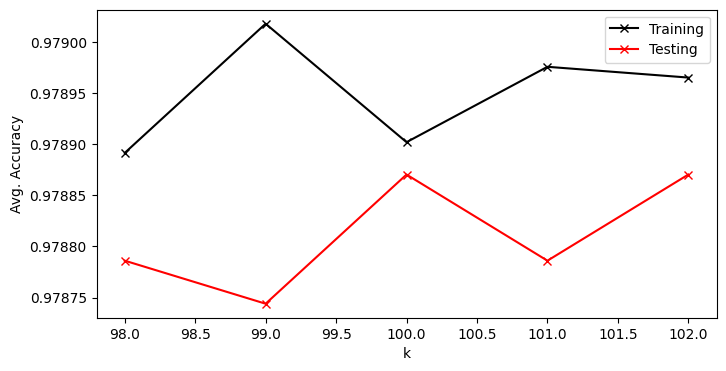

In [312]:
plt.figure(figsize=(8,4))
plt.plot(k_range, train,'-kx',label='Training')
plt.plot(k_range, test, '-rx',label='Testing')
plt.xlabel('k')
plt.ylabel('Avg. Accuracy')
plt.legend()
plt.show()

In [213]:
# Now for the ensembling...

In [231]:
def Convert_Label(probas):
    labels = []
    for proba in probas:
        if round(proba) == 1:
            labels.append("'yes'")
        else:
            labels.append("'no'")
    return labels

In [290]:
def Ensemble(models):
    probas = sum(models)/len(models)
    probas = probas[:,1]
    labels = Convert_Label(probas)
    return labels

In [320]:
X_train = X[:int(len(X)/2)]
X_train_red = X_reduced[:int(len(X_reduced)/2)]
y_train = y[:int(len(y)/2)]

X_test = X[int(len(X)/2):]
X_test_red = X_reduced[int(len(X_reduced)/2):]
y_test = y[int(len(y)/2):]

print('INDIVIDUAL MODELS')
# Logistic Regression Model
log = LR()
log.fit(X_train_red,y_train)
log_probas = log.predict_proba(X_test_red)
print(f'Logistic Regression accuracy: {log.score(X_test_red,y_test)}')

# Random Forest Model
rfc = RFC(n_estimators=5,
                  max_depth=3,
                  max_features=None, 
                  random_state=146)
rfc.fit(X_train,y_train)
rfc_probas = rfc.predict_proba(X_test)
print(f'Random Forest Classification accuracy: {rfc.score(X_test,y_test)}')

# Decision Tree Model
dtc = DTC(max_depth = 5, random_state=146)
dtc.fit(X_train,y_train)
dtc_probas = dtc.predict_proba(X_test)
print(f'Decision Tree Classification accuracy: {dtc.score(X_test,y_test)}')

# KNN Model
knn = KNN(n_neighbors=100)
knn.fit(X_train_red,y_train)
knn_probas = knn.predict_proba(X_test_red)
print(f'KNN Classifier accuracy: {knn.score(X_test_red,y_test)}')

print('\nENSEMBLE PREDICTIONS')
### Ensemble predictions
labels1 = Ensemble([log_probas, rfc_probas, dtc_probas, knn_probas])
print(f'Full Ensemble accuracy: {sum(labels1 == y_test)/len(y_test)}')

labels2 = Ensemble([knn_probas, rfc_probas, dtc_probas])
print(f'Not LOG accuracy: {sum(labels2 == y_test)/len(y_test)}')

labels3 = Ensemble([rfc_probas, dtc_probas])
print(f'RFC + DTC accuracy: {sum(labels3 == y_test)/len(y_test)}')

labels4 = Ensemble([rfc_probas, knn_probas])
print(f'RFC + KNN accuracy: {sum(labels4 == y_test)/len(y_test)}')

labels5 = Ensemble([dtc_probas, knn_probas])
print(f'DTC + KNN accuracy: {sum(labels5 == y_test)/len(y_test)}')

INDIVIDUAL MODELS
Logistic Regression accuracy: 0.8156410472261975
Random Forest Classification accuracy: 0.9410724808485563
Decision Tree Classification accuracy: 0.960097651317451
KNN Classifier accuracy: 0.9763448101692062

ENSEMBLE PREDICTIONS
Full Ensemble accuracy: 0.9760922636585572
Not LOG accuracy: 0.9762606279989898
RFC + DTC accuracy: 0.9603501978281
RFC + KNN accuracy: 0.9758397171479081
DTC + KNN accuracy: 0.9776917248926678
